In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
  
import shap  
  
from sklearn.ensemble import IsolationForest  
from ucimlrepo import fetch_ucirepo

In [2]:
# Fetch dataset from UCI repository  
power_consumption = fetch_ucirepo(id=235)  
  
print(power_consumption.variables)

/Users/du/miniforge3/envs/xai/lib/python3.11/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


                    name     role         type demographic description units  \
0                   Date  Feature         Date        None        None  None   
1                   Time  Feature  Categorical        None        None  None   
2    Global_active_power  Feature   Continuous        None        None  None   
3  Global_reactive_power  Feature   Continuous        None        None  None   
4                Voltage  Feature   Continuous        None        None  None   
5       Global_intensity  Feature   Continuous        None        None  None   
6         Sub_metering_1  Feature   Continuous        None        None  None   
7         Sub_metering_2  Feature   Continuous        None        None  None   
8         Sub_metering_3  Feature   Continuous        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no  


In [3]:
# Get all features  
data = power_consumption.data.features  
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')  
  
# List of features to check  
feature_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage',  
'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']  
  
# Convert feature columns to numeric and replace any errors with NaN  
data[feature_columns] = data[feature_columns].apply(pd.to_numeric, errors='coerce')  
  
# Drop rows where all feature columns are missing (NaN)  
data_cleaned = data.dropna(subset=feature_columns, how='all')  
  
# Drop rows where ALL feature columns are NaN  
data_cleaned.head() # Now, this is not always the best practice when doing anomaly detection. Rows with a lot of missing values might indicate that an instance is an anomaly. In this case, we’re going to keep things simple — just keep that in mind when you’re applying Isolation Forest to your problem.

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
# Group by 'Date' and calculate mean and standard deviation (ignore NaN values)  
data_aggregated = data_cleaned.groupby('Date')[feature_columns].agg(['mean', 'std'])  
  
# Rename columns to the desired format (MEAN_ColumnName, STD_ColumnName)  
data_aggregated.columns = [  
f'{agg_type.upper()}_{col}' for col, agg_type in data_aggregated.columns  
]  
  
# Reset the index  
data_aggregated.reset_index(inplace=True)  
  
# Display the result  
print(data_aggregated.shape)  
data_aggregated.head()

(1433, 15)


,Date,MEAN_Global_active_power,STD_Global_active_power,MEAN_Global_reactive_power,STD_Global_reactive_power,MEAN_Voltage,STD_Voltage,MEAN_Global_intensity,STD_Global_intensity,MEAN_Sub_metering_1,STD_Sub_metering_1,MEAN_Sub_metering_2,STD_Sub_metering_2,MEAN_Sub_metering_3,STD_Sub_metering_3
0,2006-12-16,3.053475,1.026338,0.088187,0.099014,236.243763,2.922896,13.082828,4.283262,0.000000,0.000000,1.378788,5.158545,12.439394,7.455105
1,2006-12-17,2.354486,1.205795,0.156949,0.114873,240.087028,4.051467,9.999028,5.031445,1.411806,6.813244,2.907639,8.800654,9.264583,8.645364
2,2006-12-18,1.530435,1.005074,0.112356,0.109154,241.231694,3.719576,6.421667,4.248511,0.738194,4.999534,1.820139,6.746395,9.734722,8.765125
3,2006-12-19,1.157079,1.237602,0.104821,0.101591,241.999313,3.069492,4.926389,5.238010,0.582639,4.459545,5.279167,12.771085,4.303472,7.529344
4,2006-12-20,1.545658,1.320968,0.111804,0.094926,242.308062,3.345704,6.467361,5.556587,0.000000,0.000000,1.838889,7.084353,9.765972,8.799051


In [5]:
# Parameters  
n_estimators = 100 # Number of trees  
sample_size = 256 # Number of samples used to train each tree  
contamination = 0.02 # Expected proportion of anomalies

In [6]:
# Select Features  
features = data_aggregated.drop('Date', axis=1)  
  
# Train Isolation Forest  
iso_forest = IsolationForest(n_estimators=n_estimators,  
contamination=contamination,  
max_samples=sample_size,  
random_state=42)  
  
iso_forest.fit(features)

IsolationForest(contamination=0.02, max_samples=256, random_state=42)

In [7]:
data_aggregated['anomaly_score'] = iso_forest.decision_function(features)  
data_aggregated['anomaly'] = iso_forest.predict(features)  
  
data_aggregated['anomaly'].value_counts()

 1    1404
-1      29
Name: anomaly, dtype: int64

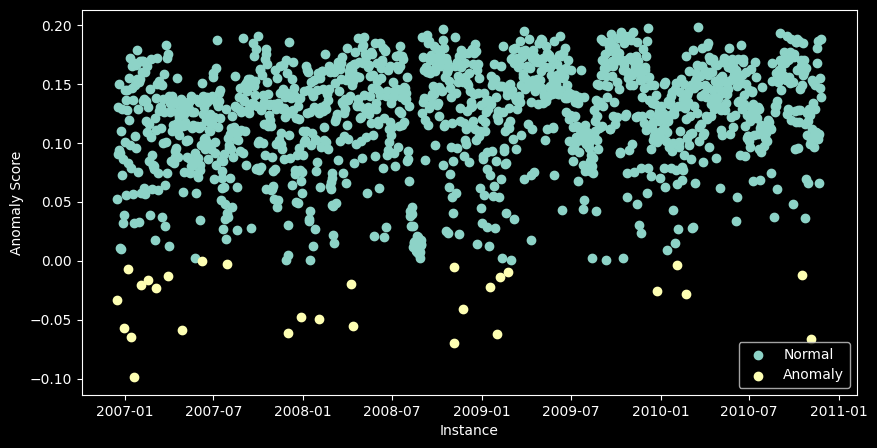

In [8]:
# Visualization of the results  
plt.figure(figsize=(10, 5))  
  
# Plot normal instances  
normal = data_aggregated[data_aggregated['anomaly'] == 1]  
plt.scatter(normal['Date'], normal['anomaly_score'], label='Normal')  
  
# Plot anomalies  
anomalies = data_aggregated[data_aggregated['anomaly'] == -1]  
plt.scatter(anomalies['Date'], anomalies['anomaly_score'], label='Anomaly')  
  
plt.xlabel("Instance")  
plt.ylabel("Anomaly Score")  
plt.legend()  
plt.show()

In [ ]:
# Using the anomaly score and TreeSHAP
explainer = shap.TreeExplainer(iso_forest, features)  
shap_values = explainer(features)

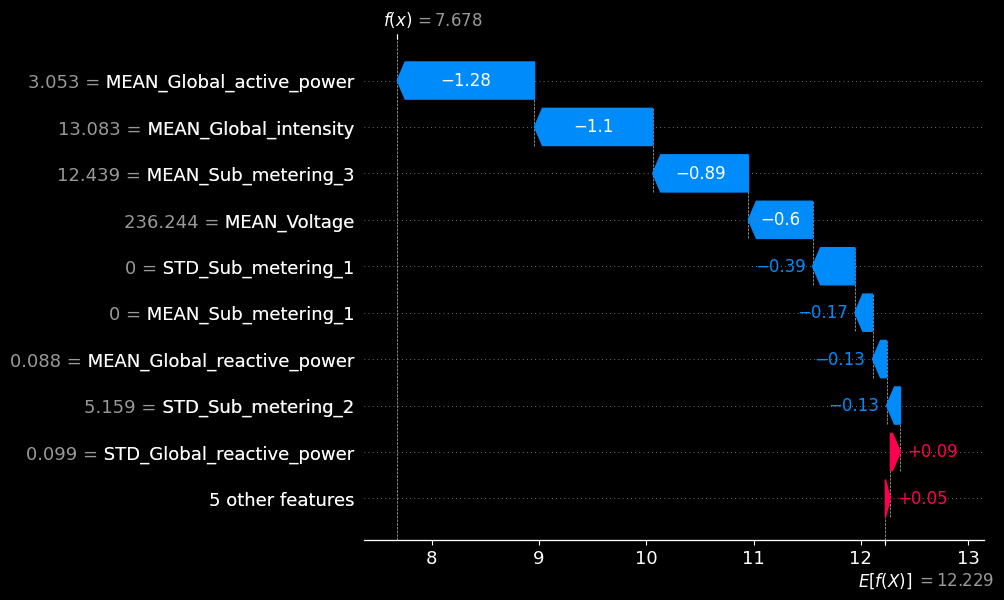

In [13]:
# Plot waterfall plot of an anomaly  
shap.plots.waterfall(shap_values[0])

In [14]:
# Select all anomalies and 100 random normal instances  
normal_sample = np.random.choice(normal.index,size=100,replace=False)  
sample = np.append(anomalies.index,normal_sample)  
  
len(sample) 

129

In [15]:
# Using the anomaly score and KernelSHAP  
explainer = shap.Explainer(iso_forest.decision_function, features)  
shap_values = explainer(features.iloc[sample])

PermutationExplainer explainer: 130it [00:25,  3.21it/s]                         


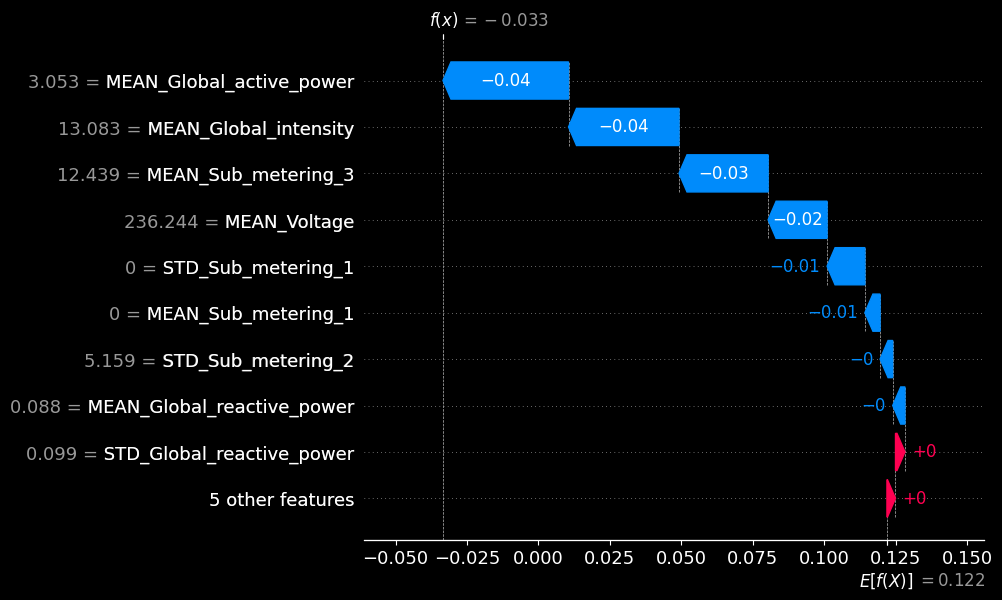

In [16]:
# Plot waterfall plot of an anomaly  
shap.plots.waterfall(shap_values[0])

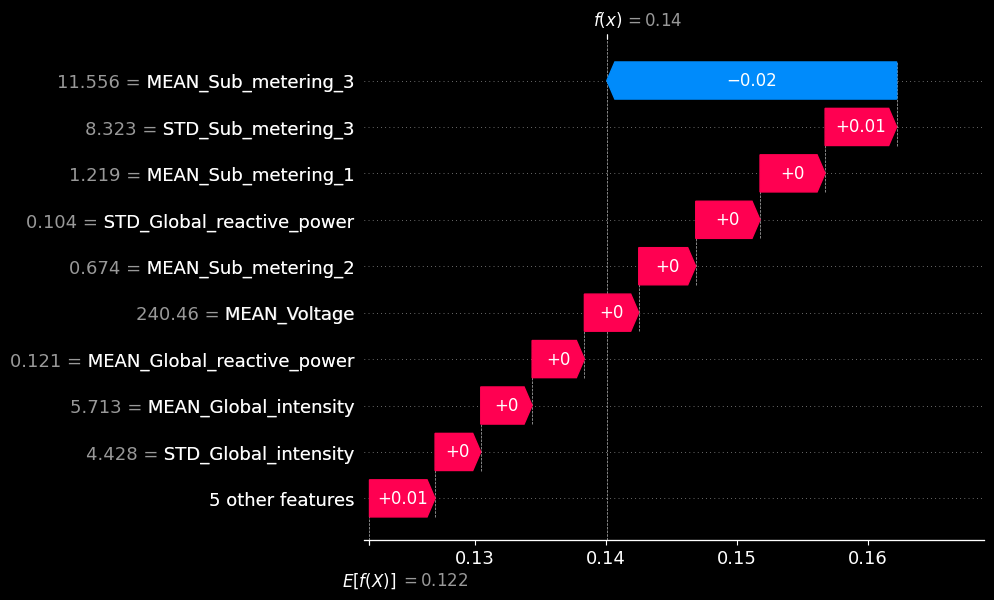

In [17]:
# Plot waterfall plot of a normal instance  
shap.plots.waterfall(shap_values[100])

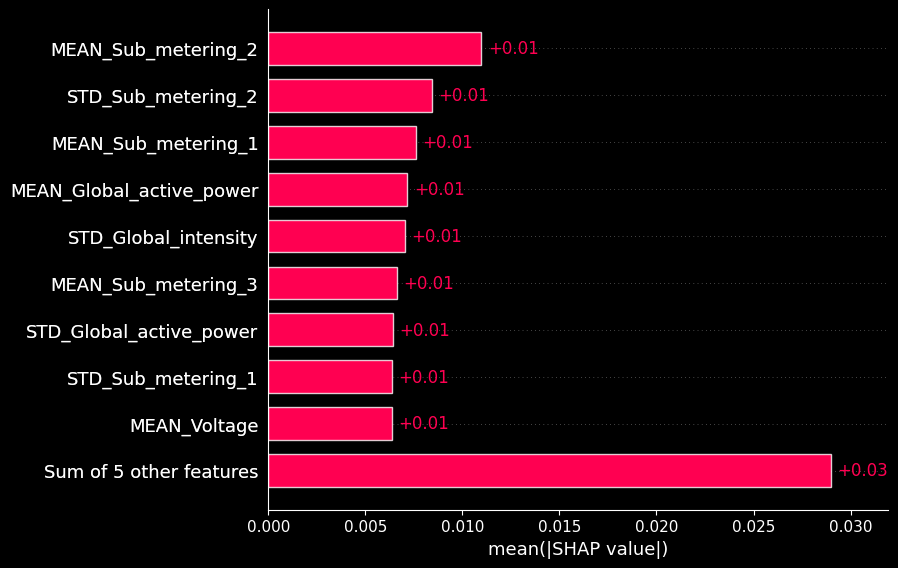

In [18]:
# MeanSHAP Plot  
shap.plots.bar(shap_values)

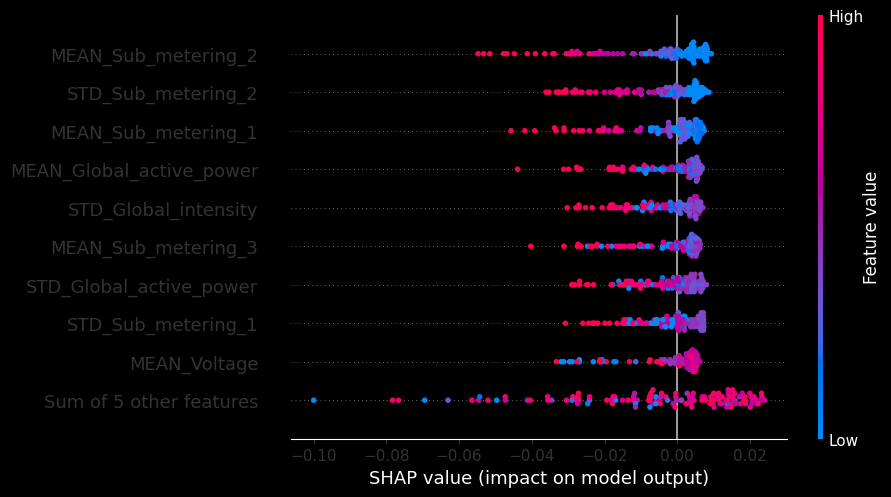

In [19]:
# Beeswarm plot  
shap.plots.beeswarm(shap_values)

In [16]:
# Calculate SHAP values  
explainer = shap.TreeExplainer(iso_forest)  
shap_values = explainer(features)

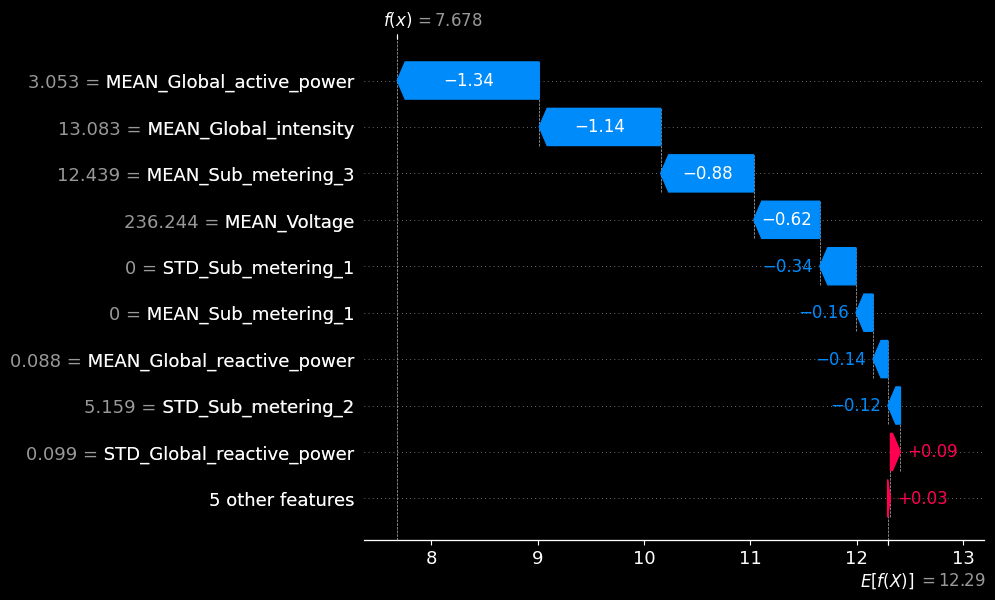

In [17]:
# Waterfall plot for an anomaly  
shap.plots.waterfall(shap_values[0])

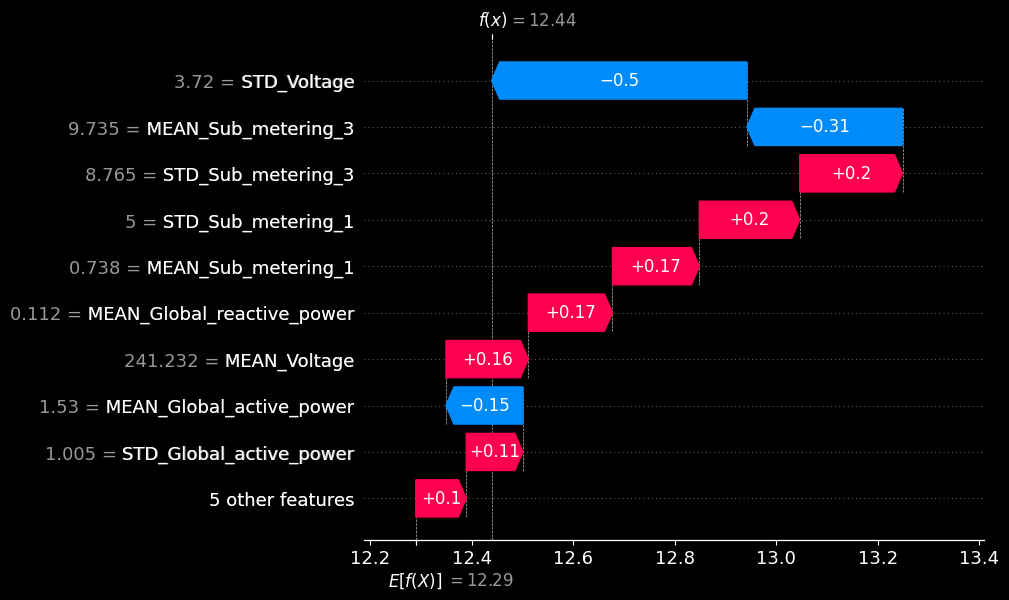

In [18]:
# Waterfall plot for a normal instance  
shap.plots.waterfall(shap_values[2])